In [ ]:
!apt-get update
!apt-get install clang libomp-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [808 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.7 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,082 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,691 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,135 kB]
Hit:9 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,974 kB]
G

In [165]:
%%writefile hello2.cpp
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <omp.h>

#define INPUT_SIZE 1000
#define HIDDEN_SIZE 256
#define OUTPUT_SIZE 100
#define LEARNING_RATE 0.001
#define ITERATIONS 2000

// Define neural network parameters
float input[INPUT_SIZE];
float hidden_weights[INPUT_SIZE][HIDDEN_SIZE];
float hidden_bias[HIDDEN_SIZE];
float hidden_output[HIDDEN_SIZE];
float output_weights[HIDDEN_SIZE][OUTPUT_SIZE];
float output_bias[OUTPUT_SIZE];
float output[OUTPUT_SIZE];

// Forward pass of the neural network
void forward_pass() {
    // Compute hidden layer output
    #pragma omp parallel for
    for (int i = 0; i < HIDDEN_SIZE; i++) {
        float sum = 0.0;
        for (int j = 0; j < INPUT_SIZE; j++) {
            sum += input[j] * hidden_weights[j][i];
        }
        float result = sum + hidden_bias[i];
        hidden_output[i] = (result > 0) ? result : 0; // ReLU activation
    }

    // Compute output layer output
    #pragma omp parallel for
    for (int i = 0; i < OUTPUT_SIZE; i++) {
        float sum = 0.0;
        for (int j = 0; j < HIDDEN_SIZE; j++) {
            sum += hidden_output[j] * output_weights[j][i];
        }
        output[i] = sum + output_bias[i];
    }
}

// Backward pass of the neural network
void backward_pass(float target[OUTPUT_SIZE]) {
    // Compute output layer gradients
    #pragma omp parallel for
    for (int i = 0; i < OUTPUT_SIZE; i++) {
        float error = output[i] - target[i];
        for (int j = 0; j < HIDDEN_SIZE; j++) {
            output_weights[j][i] -= LEARNING_RATE * error * hidden_output[j];
        }
        output_bias[i] -= LEARNING_RATE * error;
    }

    // Compute hidden layer gradients
    #pragma omp parallel for
    for (int i = 0; i < HIDDEN_SIZE; i++) {
        float error = 0.0;
        for (int j = 0; j < OUTPUT_SIZE; j++) {
            error += (output[j] - target[j]) * output_weights[i][j];
        }
        error *= (hidden_output[i] > 0) ? 1 : 0; // ReLU derivative
        for (int j = 0; j < INPUT_SIZE; j++) {
            hidden_weights[j][i] -= LEARNING_RATE * error * input[j];
        }
        hidden_bias[i] -= LEARNING_RATE * error;
    }
}

int main() {
    // Set the number of threads used by OpenMP
    int num_threads = 2;  // Change this to the desired number of threads
    omp_set_num_threads(num_threads);

    // Initialize neural network parameters
    // (Initialization code omitted for brevity)

    // Dummy input (for demonstration purposes)
    for (int i = 0; i < INPUT_SIZE; i++) {
        input[i] = (float)(rand()) / RAND_MAX;
    }

    // Dummy target output (for demonstration purposes)
    float target[OUTPUT_SIZE] = {0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0};

    // Timing code
    clock_t start_time = clock();

    // Perform multiple iterations of forward and backward passes
    for (int iter = 0; iter < ITERATIONS; iter++) {
        forward_pass();
        backward_pass(target);
    }

    clock_t end_time = clock();
    double total_time = (double)(end_time - start_time) / CLOCKS_PER_SEC;
    printf("Total time: %f seconds\n", total_time);

    return 0;
}


Overwriting hello2.cpp


In [166]:
!clang++ -fopenmp hello2.cpp -o hello2

hello2.cpp:82:38: warning: implicit conversion from 'int' to 'float' changes
      value from 2147483647 to 2147483648 [-Wimplicit-const-int-float-conversion]
        input[i] = (float)(rand()) / RAND_MAX;
                                   ~ ^~~~~~~~
/usr/include/stdlib.h:87:18: note: expanded from macro 'RAND_MAX'
#define RAND_MAX        2147483647
                        ^~~~~~~~~~
1 warning generated.


In [167]:
!./hello2

Total time: 9.249367 seconds


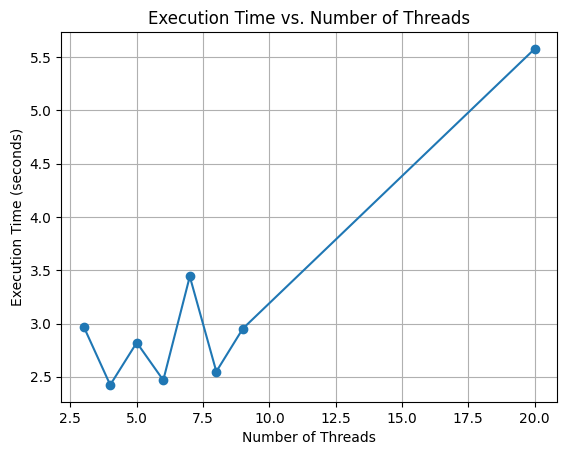

In [ ]:
import matplotlib.pyplot as plt

# Number of threads used
num_threads = [3, 4, 5, 6, 7, 8, 9, 20]

# Execution time for each number of threads
execution_time = [2.9708, 2.4236, 2.821, 2.468, 3.4418, 2.5488, 2.952, 5.5775]

# Plot the data
plt.plot(num_threads, execution_time, marker='o')
plt.title('Execution Time vs. Number of Threads')
plt.xlabel('Number of Threads')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()


In [162]:
import matplotlib.pyplot as plt
from tabulate import tabulate

# Number of threads used
num_threads = [3, 4, 5, 6, 7, 8, 9, 20]

# Execution time for each number of threads
execution_time = [2.9708, 2.4236, 2.821, 2.468, 3.4418, 2.5488, 2.952, 5.5775]

# Create a table
table_data = zip(num_threads, execution_time)
headers = ["Number of Threads", "Execution Time (seconds)"]
table = tabulate(table_data, headers=headers, tablefmt="grid")


# Show the table
print(table)

# Show the plot
plt.show()


+---------------------+----------------------------+
|   Number of Threads |   Execution Time (seconds) |
+=====================+============================+
|                   3 |                     2.9708 |
+---------------------+----------------------------+
|                   4 |                     2.4236 |
+---------------------+----------------------------+
|                   5 |                     2.821  |
+---------------------+----------------------------+
|                   6 |                     2.468  |
+---------------------+----------------------------+
|                   7 |                     3.4418 |
+---------------------+----------------------------+
|                   8 |                     2.5488 |
+---------------------+----------------------------+
|                   9 |                     2.952  |
+---------------------+----------------------------+
|                  20 |                     5.5775 |
+---------------------+-----------------------